## Dog License Machine Learning
### David DeBow
### Justin Johnson
### Ryan Parker
### Feb 15, 2023


Exploration of Names

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import graphviz 
# cite https://stackoverflow.com/questions/74877602/getting-a-warning-when-using-sklearn-neighbors-about-keepdims
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

sns.set()
rcParams['figure.figsize'] = 8,6
sns.set_context('talk')   # 'talk' for slightly larger

In [2]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

In [3]:
# The original CSV is too large for github. It is 31mb and github accepts 25mb or less.
# The plan is to split the files and merge them on read.
# We found a website that can split CSVs online. https://www.splitcsv.com/
# Successfully split but ran in to problems
# For now we will host on Dropbox. Dropbox can handle larger files when not using a webbrowser.
# Error, need to change domain to direct download. Went from dropbox.com to dl.dropboxusercontent.com
df = pd.read_csv("http://dl.dropboxusercontent.com/s/0uzku9gb353n3nv/NYC_Dog_Licensing_Dataset.csv")

dfBaby = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00591/name_gender_dataset.csv")

The choice of dataset is Animal (Dog) License Data from NYC from data.gov . The file is approximately 31 megabytes and holds 500,000 lines of data. It is hosted on a dropbox for ease of use.

We are going to predict the AnimalName. There are 8 columns of data, but we are most interested in the AnimalName.

The predictors we will be using are ZipCode and Birthyear. 

Preprocessing, exploration, and visualization, and machine learning work are below.

In [4]:
#Let us look at the information and general data of the chart.
df.info()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508196 entries, 0 to 508195
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   AnimalName          507169 non-null  object 
 1   AnimalGender        508175 non-null  object 
 2   AnimalBirthYear     508196 non-null  int64  
 3   BreedName           508196 non-null  object 
 4   ZipCode             508187 non-null  float64
 5   LicenseIssuedDate   508196 non-null  object 
 6   LicenseExpiredDate  508119 non-null  object 
 7   Extract Year        508196 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 31.0+ MB
       AnimalBirthYear        ZipCode   Extract Year
count    508196.000000  508187.000000  508196.000000
mean       2013.206304   10704.532395    2019.380810
std           4.847849    1096.178521       2.646618
min        1991.000000       0.000000    2016.000000
25%        2010.000000   10031.000000    2017.000000
50%      

data['Gender'].replace(0, 'Female',inplace=True)
data['Gender'].replace(1, 'Male',inplace=True)

In [5]:
#Let us look at the information and general data of the chart.
dfBaby.info()
print(dfBaby.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147269 entries, 0 to 147268
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Name         147269 non-null  object 
 1   Gender       147269 non-null  object 
 2   Count        147269 non-null  int64  
 3   Probability  147269 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.5+ MB
              Count   Probability
count  1.472690e+05  1.472690e+05
mean   2.481161e+03  6.790295e-06
std    4.645472e+04  1.271345e-04
min    1.000000e+00  2.736740e-09
25%    5.000000e+00  1.368370e-08
50%    1.700000e+01  4.652460e-08
75%    1.320000e+02  3.612500e-07
max    5.304407e+06  1.451679e-02


In [6]:
#sns.pairplot(df)
#df.plot()

How many Zipcodes are there? 

In [7]:
df['ZipCode'].value_counts().head(10)


10025.0    11439
10023.0     9164
11215.0     8829
10024.0     8826
11201.0     8757
10011.0     8555
10128.0     8392
10009.0     8073
10314.0     7613
10312.0     7467
Name: ZipCode, dtype: int64

In [8]:
df['ZipCode'].value_counts().size

784

There are 740 zip codes.

What are the most popular animal names?

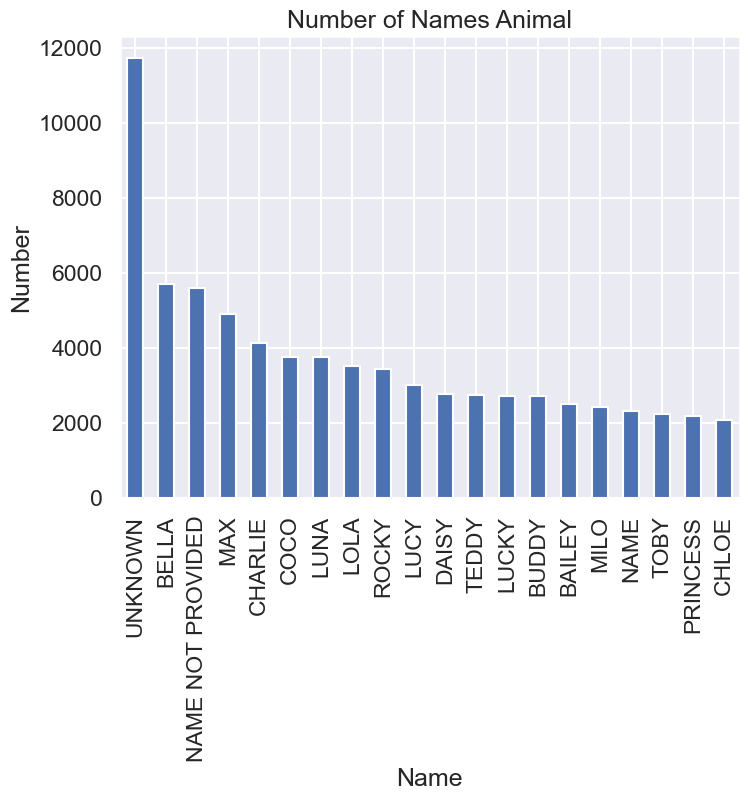

In [9]:
#@ 1 Show the top 20 names
names = df['AnimalName'].value_counts().head(20)
names.plot.bar()
plt.xlabel("Name")
plt.ylabel("Number")
plt.title("Number of Names Animal");

We need to clean up the data. The most popular name is uknown and second most popular is name not provided.[

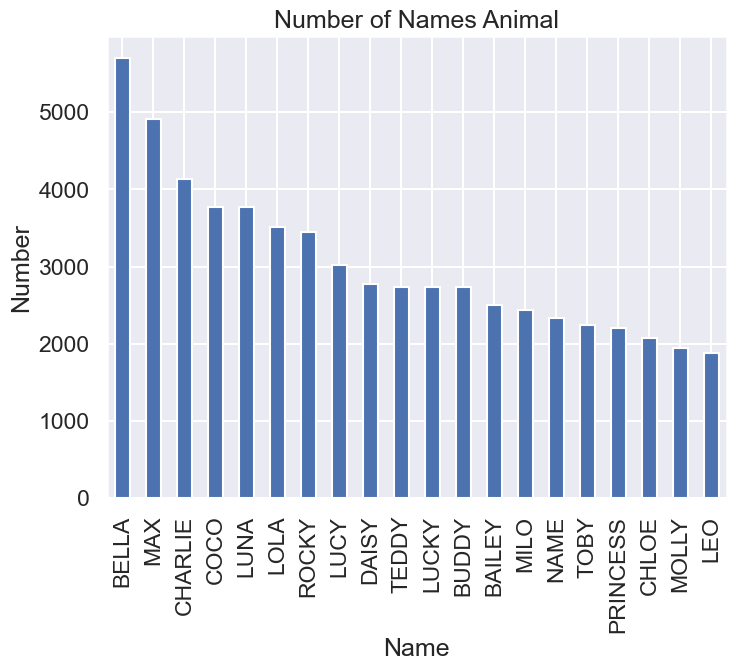

In [10]:
#Drop junk names

df = df[df.AnimalName != 'UNKNOWN']
df = df[df.AnimalName != 'NAME NOT PROVIDED']


#@ 1 Show the top 20 names after dropping junk names
names = df['AnimalName'].value_counts().head(20)
names.plot.bar()
plt.xlabel("Name")
plt.ylabel("Number")
plt.title("Number of Names Animal");


Let us clean up the data further.

In [11]:
# DATA PREPARATION
print(df.isnull().sum())
# na values:
# AnimalName: 1027
# AnimalGender: 21
# ZipCode: 9
# LicenseExpiredDate: 77
# while we could dropna on all values, we are only doing so on AnimalGender
# we plan to predict BreedName using AnimalGender and Extract Year, so others are not required

# predicting AnimalName (or lack of name) using ZipCode and AnimalBirthYear sounds very interesting; however,
# the feedback stated that predictions using zipcodes and dates is difficult, so I think we should explore the
# relationship between these using plots instead. Such as

# easy way to show dropped columns
df_dropped = df[df['AnimalGender'].isna()]
print(df_dropped)

# drop rows that contain na in AnimalGender column
df = df[df['AnimalGender'].notna()]
#print(df.isnull().sum())


AnimalName            1027
AnimalGender            21
AnimalBirthYear          0
BreedName                0
ZipCode                  9
LicenseIssuedDate        0
LicenseExpiredDate      44
Extract Year             0
dtype: int64
       AnimalName AnimalGender  AnimalBirthYear  \
7356      SPARKEY          NaN             2005   
16436      SHEBAH          NaN             1997   
16684      SHEBAH          NaN             1997   
17929      SHEBAH          NaN             1997   
18002      SHEBAH          NaN             1997   
47593       BUDDY          NaN             2005   
57191       NANUK          NaN             2000   
69701      SIDNEY          NaN             2003   
110361     CHERRY          NaN             2002   
112674      NANUK          NaN             2000   
115288    SPARKEY          NaN             2005   
123852      BUDDY          NaN             2005   
142049     SIDNEY          NaN             2003   
194786    SPARKEY          NaN             2005   
198415

Experimenting with data.

In [12]:
#Label enconding from 

def Encoder(df):
          columnsToEncode = list(df.select_dtypes(include=['category','object']))
          le = LabelEncoder()
          for feature in columnsToEncode:
              try:
                  df[feature] = le.fit_transform(df[feature])
              except:
                  print('Error encoding '+feature)
          return df

Machine Learning and Predictions,

In [13]:
#preserve index values

df = df.drop('ZipCode', axis=1)

df['oldIndex'] = df.index
df['oldName'] = df.index

dfConvert = df.copy()

#get rid of strings
dfE = Encoder(df)

df = pd.read_csv("http://dl.dropboxusercontent.com/s/0uzku9gb353n3nv/NYC_Dog_Licensing_Dataset.csv")

df = df[df.AnimalName != 'UNKNOWN']
df = df[df.AnimalName != 'NAME NOT PROVIDED']

df = df.drop('ZipCode', axis=1)


#show top 10
dfE.head(10)
    
X0 = dfE.iloc[:,[0] ].values #AnimalName
X1 = dfE.iloc[:,[0,2] ].values #AnimalName, AnimalBirthYear
X2 = dfE.iloc[:,[0,2,7] ].values #AnimalName, AnimalBirthYear, Extract Year
X3 = dfE.iloc[:,[0,2,7] ].values #AnimalName, AnimalBirthYear, Extract year
X4 = dfE.iloc[:,[0,2,3] ].values #AnimalName, AnimalBirthYear, BreedName
X5 = dfE.iloc[:,[0,7] ].values #AnimalName, AnimalBirthYear
X6 = dfE.iloc[:,[0,7,3] ].values #AnimalName, Extract Year, BreedName
X7 = dfE.iloc[:,[0,7,3] ].values #AnimalName, Extract Year, BreedName 
X8 = dfE.iloc[:,[0,7] ].values #AnimalName, Extract Year
X9 = dfE.iloc[:,[0,2,4,7] ].values #AnimalName, AnimalBirthYear, BreedName, Extract Year
X10 = dfE.iloc[:,[0,2,4,7] ].values #AnimalName, AnimalBirthYear, BreedName, Extract Year

stringX = ["1","1","1","1","1","1","1","1","1","1","1"]
stringX[0]= "AnimalName"
stringX[1]="AnimalName, AnimalBirthYear"
stringX[2]="AnimalName, AnimalBirthYear, Extract Year"
stringX[3]="AnimalName, AnimalBirthYear, Extract Year"
stringX[4]="AnimalName, AnimalBirthYear, BreedName"
stringX[5]="AnimalName, AnimalBirthYear"
stringX[6]="AnimalName, Extract Year, BreedName"
stringX[7]="AnimalName, Extract Year, BreedName"
stringX[8]="AnimalName, Extract Year"
stringX[9]="AnimalName, AnimalBirthYear, BreedName, Extract Year"
stringX[10]="AnimalName, AnimalBirthYear, BreedName, Extract Year"



#y is animal gender
y = dfE.iloc[:,[1]].values.ravel()

#y2 is breed for curiosity
y2 = dfE.iloc[:,[2]].values.ravel()


In [14]:
dfE.head(10)

,AnimalName,AnimalGender,AnimalBirthYear,BreedName,LicenseIssuedDate,LicenseExpiredDate,Extract Year,oldIndex,oldName
0,19476,0,2014,44,1780,2936,2016,0,0
1,28351,1,2010,196,1780,3166,2016,1,1
2,462,1,2014,120,1780,2938,2016,2,2
3,21233,0,2013,32,1780,2936,2016,3,3
4,15038,0,2009,777,1780,3243,2016,4,4
5,11448,1,2006,1316,1780,3486,2016,5,5
6,3683,1,2008,1316,1780,3370,2016,6,6
7,4986,0,2012,697,1780,3157,2016,7,7
8,10884,0,2007,414,1788,1227,2016,8,8
9,16253,1,2009,217,1788,2992,2016,9,9


In [15]:
dfConvert.head(10)

,AnimalName,AnimalGender,AnimalBirthYear,BreedName,LicenseIssuedDate,LicenseExpiredDate,Extract Year,oldIndex,oldName
0,PAIGE,F,2014,American Pit Bull Mix / Pit Bull Mix,09/12/2014,09/12/2017,2016,0,0
1,YOGI,M,2010,Boxer,09/12/2014,10/02/2017,2016,1,1
2,ALI,M,2014,Basenji,09/12/2014,09/12/2019,2016,2,2
3,QUEEN,F,2013,Akita Crossbreed,09/12/2014,09/12/2017,2016,3,3
4,LOLA,F,2009,Maltese,09/12/2014,10/09/2017,2016,4,4
5,IAN,M,2006,Unknown,09/12/2014,10/30/2019,2016,5,5
6,BUDDY,M,2008,Unknown,09/12/2014,10/20/2017,2016,6,6
7,CHEWBACCA,F,2012,Labrador Retriever Crossbreed,09/12/2014,10/01/2019,2016,7,7
8,HEIDI-BO,F,2007,Dachshund Smooth Coat,09/13/2014,04/16/2017,2016,8,8
9,MASSIMO,M,2009,"Bull Dog, French",09/13/2014,09/17/2017,2016,9,9


In [16]:
dfBaby.head(10)

,Name,Gender,Count,Probability
0,James,M,5304407,0.014517
1,John,M,5260831,0.014398
2,Robert,M,4970386,0.013603
3,Michael,M,4579950,0.012534
4,William,M,4226608,0.011567
5,Mary,F,4169663,0.011411
6,David,M,3787547,0.010366
7,Joseph,M,2695970,0.007378
8,Richard,M,2638187,0.007220
9,Charles,M,2433540,0.006660


In [17]:
dfE.index.value_counts().sum()

490848

In [18]:
dfBaby['Name'] = dfBaby['Name'].str.upper()

Convert to upper for baby names

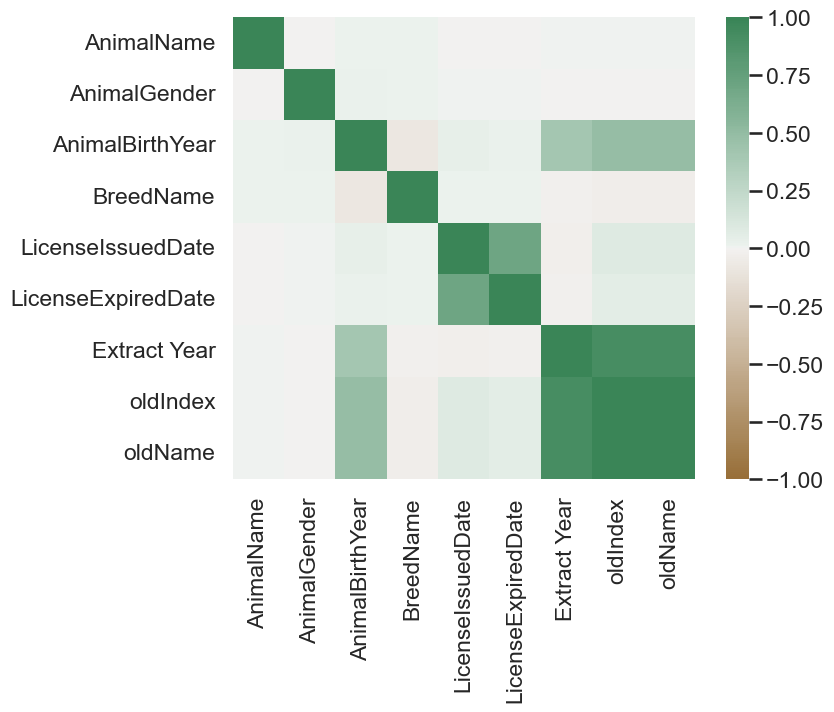

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_full_health = dfE.corr()

#cite https://seaborn.pydata.org/generated/seaborn.heatmap.html 

axis_corr = sns.heatmap(
correlation_full_health,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(50, 500, n=500),
square=True
)

plt.show() 

In [20]:
dfE.head(10)

,AnimalName,AnimalGender,AnimalBirthYear,BreedName,LicenseIssuedDate,LicenseExpiredDate,Extract Year,oldIndex,oldName
0,19476,0,2014,44,1780,2936,2016,0,0
1,28351,1,2010,196,1780,3166,2016,1,1
2,462,1,2014,120,1780,2938,2016,2,2
3,21233,0,2013,32,1780,2936,2016,3,3
4,15038,0,2009,777,1780,3243,2016,4,4
5,11448,1,2006,1316,1780,3486,2016,5,5
6,3683,1,2008,1316,1780,3370,2016,6,6
7,4986,0,2012,697,1780,3157,2016,7,7
8,10884,0,2007,414,1788,1227,2016,8,8
9,16253,1,2009,217,1788,2992,2016,9,9


In [21]:
xTotal = [X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10]
kTotal = [0 ,1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10]
neighborTotal = [0 , 0,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0]

count = 0

results = ["1","1","1","1","1","1","1","1","1","1","1"]

for X in xTotal:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    for noK in range(1, 10):

        classifier = KNeighborsClassifier(n_neighbors = noK)
        classifier.fit(X_train, y_train)


        y_pred = classifier.predict(X_test)

        accuracy = accuracy_score(y_test,y_pred)
        
        if accuracy>neighborTotal[count]:
            neighborTotal[count]= accuracy
            
            kTotal[count] = noK

    
    results[count]= "Optimal Accuracy Score of "+str(neighborTotal[count])+"Best K ("+str(kTotal[count])+") "+str(stringX[count])
    count += 1

for result in results:
    print(result)

Optimal Accuracy Score of 0.8678042897190169Best K (5) AnimalName
Optimal Accuracy Score of 0.8675516656887672Best K (1) AnimalName, AnimalBirthYear
Optimal Accuracy Score of 0.6420073016493905Best K (1) AnimalName, AnimalBirthYear, Extract Year
Optimal Accuracy Score of 0.6423577156268335Best K (1) AnimalName, AnimalBirthYear, Extract Year
Optimal Accuracy Score of 0.856036899406741Best K (1) AnimalName, AnimalBirthYear, BreedName
Optimal Accuracy Score of 0.7034030901623313Best K (1) AnimalName, AnimalBirthYear
Optimal Accuracy Score of 0.6287323163178825Best K (1) AnimalName, Extract Year, BreedName
Optimal Accuracy Score of 0.6301095247408567Best K (1) AnimalName, Extract Year, BreedName
Optimal Accuracy Score of 0.7047314036117087Best K (1) AnimalName, Extract Year
Optimal Accuracy Score of 0.5544771497490057Best K (7) AnimalName, AnimalBirthYear, BreedName, Extract Year
Optimal Accuracy Score of 0.5546890279679249Best K (9) AnimalName, AnimalBirthYear, BreedName, Extract Year


In [22]:
xTotal = [X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10]

count = 0

for X in xTotal:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    classifier = KNeighborsClassifier(n_neighbors = kTotal[count])
    classifier.fit(X_train, y_train)


    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test,y_pred)

    print("Optimized Accuracy Score of "+str(count) + ": " +str(accuracy)+" ("+stringX[count]+")")
    
    count+=1

Optimized Accuracy Score of 0: 0.8636726644500945 (AnimalName)
Optimized Accuracy Score of 1: 0.8678450355303475 (AnimalName, AnimalBirthYear)
Optimized Accuracy Score of 2: 0.643963100593259 (AnimalName, AnimalBirthYear, Extract Year)
Optimized Accuracy Score of 3: 0.6408990155811982 (AnimalName, AnimalBirthYear, Extract Year)
Optimized Accuracy Score of 4: 0.8538366255948888 (AnimalName, AnimalBirthYear, BreedName)
Optimized Accuracy Score of 5: 0.7048128952343699 (AnimalName, AnimalBirthYear)
Optimized Accuracy Score of 6: 0.6294575917595672 (AnimalName, Extract Year, BreedName)
Optimized Accuracy Score of 7: 0.6326194667188213 (AnimalName, Extract Year, BreedName)
Optimized Accuracy Score of 8: 0.7046743594758459 (AnimalName, Extract Year)
Optimized Accuracy Score of 9: 0.5543956581263446 (AnimalName, AnimalBirthYear, BreedName, Extract Year)
Optimized Accuracy Score of 10: 0.5537437251450551 (AnimalName, AnimalBirthYear, BreedName, Extract Year)


After finding the optimal predictors, we produce an accuracy score and classification report.

In [23]:
X = X1

#Animal name animal birth year

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors = 1)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_test)

print("accuracy_score:")
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)
print(" ")
print("classification_report:")
classification = classification_report(y_test, y_pred)
print(classification)


accuracy_score:
0.8663374405111155
 
classification_report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     56143
           1       0.88      0.88      0.88     66569

    accuracy                           0.87    122712
   macro avg       0.87      0.87      0.87    122712
weighted avg       0.87      0.87      0.87    122712



In [24]:
df.head(10)
dfE.head(10)

,AnimalName,AnimalGender,AnimalBirthYear,BreedName,LicenseIssuedDate,LicenseExpiredDate,Extract Year,oldIndex,oldName
0,19476,0,2014,44,1780,2936,2016,0,0
1,28351,1,2010,196,1780,3166,2016,1,1
2,462,1,2014,120,1780,2938,2016,2,2
3,21233,0,2013,32,1780,2936,2016,3,3
4,15038,0,2009,777,1780,3243,2016,4,4
5,11448,1,2006,1316,1780,3486,2016,5,5
6,3683,1,2008,1316,1780,3370,2016,6,6
7,4986,0,2012,697,1780,3157,2016,7,7
8,10884,0,2007,414,1788,1227,2016,8,8
9,16253,1,2009,217,1788,2992,2016,9,9


RMSE 1: 0.50


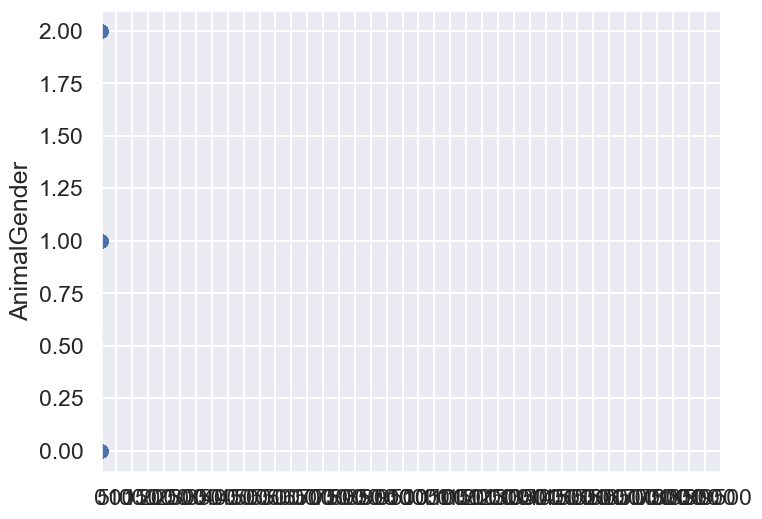

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490869 entries, 0 to 508195
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   AnimalName          490869 non-null  int64
 1   AnimalGender        490869 non-null  int64
 2   AnimalBirthYear     490869 non-null  int64
 3   BreedName           490869 non-null  int64
 4   LicenseIssuedDate   490869 non-null  int64
 5   LicenseExpiredDate  490869 non-null  int64
 6   Extract Year        490869 non-null  int64
dtypes: int64(7)
memory usage: 30.0 MB


,AnimalName,AnimalGender,AnimalBirthYear,BreedName,LicenseIssuedDate,LicenseExpiredDate,Extract Year
0,19476,0,2014,44,1780,2936,2016
1,28351,1,2010,196,1780,3166,2016
2,462,1,2014,120,1780,2938,2016
3,21233,0,2013,32,1780,2936,2016
4,15038,0,2009,777,1780,3243,2016
5,11448,1,2006,1316,1780,3486,2016
6,3683,1,2008,1316,1780,3370,2016
7,4986,0,2012,697,1780,3157,2016
8,10884,0,2007,414,1788,1227,2016
9,16253,1,2009,217,1788,2992,2016


In [25]:
#get rid of strings
df = Encoder(df)

#drop infinites
df = df[np.isfinite(df).all(1)]

predictors = ['AnimalName', 'AnimalBirthYear']

target = 'AnimalGender'
X = df[predictors].values
y = df[target].values

#use random state 42 70/30 split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=.30,random_state=42)

#fit the linear model
regr=LinearRegression()
regr.fit(X_train, y_train)
#get prediction
predicted=regr.predict(X_test)

rmse=np.sqrt(((y_test - predicted)**2).mean())
print('RMSE 1: {:.2f}'.format(rmse))

length_of_first = len(df['AnimalName'])
#df['BreedName'].values.reshape((-1, length_of_first))
predicted.resize((length_of_first))

sns.regplot(x=predicted, y='AnimalGender', data=df)
plt.xticks(np.arange(0,20000,500))
plt.show()

df.info()
df.head(10)


We'll have to figure out what the next steps are given that we have a horizontal line for our fit.

Code that makes a prediction of genders based of names using a decision tree. Then its plots the actual gender count to the predicted count if you think it would be good to add here it is but if not thats okay lol the code is kind of long tho

Accuracy: 0.86


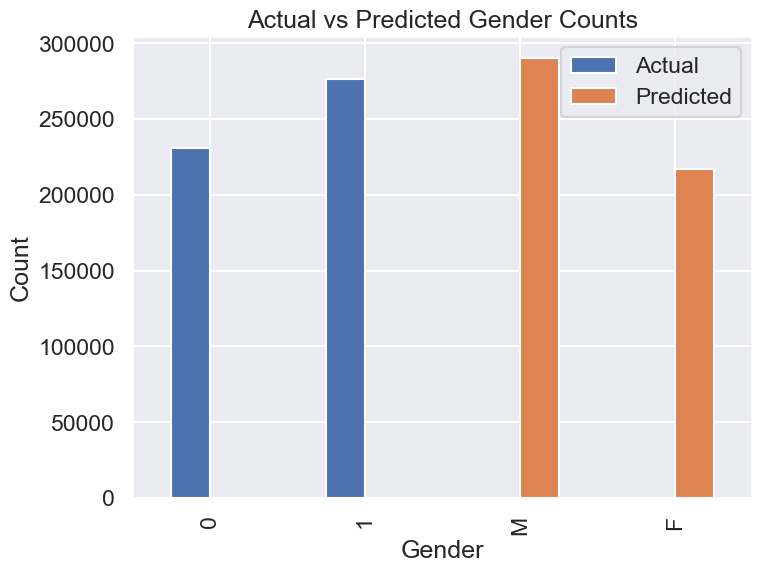

In [26]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("http://dl.dropboxusercontent.com/s/0uzku9gb353n3nv/NYC_Dog_Licensing_Dataset.csv")

# Filter out rows with NaN names and gender
df = df[['AnimalName', 'AnimalGender']].dropna()
df = df[df['AnimalGender'] != 'Unknown']

# Encode gender as numerical value
le = LabelEncoder()
df['AnimalGender'] = le.fit_transform(df['AnimalGender'])

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_features = df['AnimalName'][:train_size]
train_labels = df['AnimalGender'][:train_size]
test_features = df['AnimalName'][train_size:]
test_labels = df['AnimalGender'][train_size:]

# Transform names to feature vectors using character frequency
char_freqs = {}
for name in train_features:
    for char in name:
        if char not in char_freqs:
            char_freqs[char] = 0
        char_freqs[char] += 1
char_freqs = {char: idx for idx, char in enumerate(sorted(char_freqs.keys()))}

train_feature_vectors = []
for name in train_features:
    freq_vec = [0] * len(char_freqs)
    for char in name:
        if char in char_freqs:
            freq_vec[char_freqs[char]] += 1
    train_feature_vectors.append(freq_vec)

test_feature_vectors = []
for name in test_features:
    freq_vec = [0] * len(char_freqs)
    for char in name:
        if char in char_freqs:
            freq_vec[char_freqs[char]] += 1
    test_feature_vectors.append(freq_vec)

# Train a decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(train_feature_vectors, train_labels)

# Make predictions on the test set
predictions = clf.predict(test_feature_vectors)

# Calculate accuracy
accuracy = sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy:.2f}")

# Predict genders for all names in the dataset
all_features = df['AnimalName']
all_feature_vectors = []
for name in all_features:
    freq_vec = [0] * len(char_freqs)
    for char in name:
        if char in char_freqs:
            freq_vec[char_freqs[char]] += 1
    all_feature_vectors.append(freq_vec)
all_predictions = clf.predict(all_feature_vectors)
predicted_genders = le.inverse_transform(all_predictions)

# Plot predicted gender distribution
gender_counts = df.groupby('AnimalGender').size()
predicted_gender_counts = pd.Series(predicted_genders).value_counts()
combined_counts = pd.concat([gender_counts, predicted_gender_counts], axis=1)
combined_counts.columns = ['Actual', 'Predicted']
combined_counts.plot(kind='bar')
plt.title('Actual vs Predicted Gender Counts')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd


# Filter out rows with NaN names and gender
df = df[['AnimalName', 'AnimalGender']].dropna()
df = df[df['AnimalGender'] != 'Unknown']

# Encode gender as numerical value
le = LabelEncoder()
df['AnimalGender'] = le.fit_transform(df['AnimalGender'])

# Transform names to feature vectors using character frequency
char_freqs = {}
for name in df['AnimalName']:
    for char in name:
        if char not in char_freqs:
            char_freqs[char] = 0
        char_freqs[char] += 1
char_freqs = {char: idx for idx, char in enumerate(sorted(char_freqs.keys()))}

feature_vectors = []
for name in df['AnimalName']:
    freq_vec = [0] * len(char_freqs)
    for char in name:
        if char in char_freqs:
            freq_vec[char_freqs[char]] += 1
    feature_vectors.append(freq_vec)

labels = df['AnimalGender']

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_features = feature_vectors[:train_size]
train_labels = labels[:train_size]
test_features = feature_vectors[train_size:]
test_labels = labels[train_size:]

# Train and test the KNN classifier for different values of N
best_n = 0
best_accuracy = 0
for n in range(1, 21):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(train_features, train_labels)
    predictions = clf.predict(test_features)
    accuracy = sum(predictions == test_labels) / len(test_labels)
    print(f"N={n}: Accuracy={accuracy:.2f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n = n

# Print the optimal value of N
print(f"Optimal N: {best_n}")

KeyboardInterrupt: 